In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
try:
    df = pd.read_csv("output.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'Gates_Foundation_Project_Data.xlsx - Sheet2.csv' was not found. Please ensure the file is in the correct directory.")
    # Exiting the script if the file is not found
    exit()

Dataset loaded successfully.


C:\Users\zainm\AppData\Local\Temp\ipykernel_57524\696079092.py:2: DtypeWarning: Columns (11,26,30,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("output.csv")


In [ ]:
training_columns = [
    'PatientAge', 'PatientHasPosGp', 'PartenerHasPosGp', 'bmi', 'conception',
    'First degree relative with following medical conditions', 'PreviouslyDiagnosedMedicalConditions',
    'Number of Previous Childbirths after 28 Weeks', 'Outcome of Previous Pregnancies (Select all that apply):',
    'Mode of Delivery in Previous Pregnancies', 'History of Ruptured Uterus',
    'Number of Abortions (Births before 28 Weeks)', 'Interval from Last Pregnancy (in years)',
    'Previous history of Intrauterine Growth Restriction (IUGR)',
    'Any other Antenatal, Postnatal, or Delivery Complications both fetal and maternal',
    'If responded "Yes" in previous question, then please specify',
    'Gestational Age (GA) (in weeks)', 'Labor Pains currently',
    'Watery Vaginal Discharge currently', 'Bleeding/Spotting currently',
    'Reduced Fetal Movement (FM) currently', 'Mental Health Symptoms',
    'Other Symptoms (Select all that apply)',
    'Medicines in Use currently',
    'Previous Medicines Record (used for long term or frequently taken):',
    'Number of Cesarean Sections (C-sections)',
    'Number of ERPC (Evacuation of Retained Products of Conception)',
    'Previous history of PPH (Postpartum Hemorrhage) Exploration',
    'Any Anesthesia Complication previously',
    'Pallor', 'Jaundice', 'Thyroid enlarged', 'Edema', 'Coarse facial hair',
    'Systolic B.P', 'Diastolic BP', 'Pulse in full 1 minute',
    'Respiratory rate in full 1 minute', 'Temp. ( armpit for 2 ) in *F',
    'Per abdominal examination : Fundal height in weeks',
    'Per abdominal examination: Lie', 'Per abdominal examination: Presentation',
    'Per speculum examination',
    'Per speculum examination (If Yes, specify findings)',
    'Per vaginal examination',
    'Per vaginal examination (If Yes, specify findings)',
    'Mode_of_delivery2',
    'History of any abdominal or pelvic surgery',
    'Any Uterine Surgery previously (Other than Cesarean Section)'
]

target_column = 'Antenatal_Peripartum_Maternal_Complications'


In [4]:
# Check if required columns exist in the DataFrame
required_columns = training_columns + [target_column]
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    print(f"Error: The following required columns are missing from the dataset: {missing_columns}")
    # Exiting the script if required columns are not found
    exit()

In [5]:
print("\n--- Initial Data Exploration ---")
print(f"Total number of rows: {df.shape[0]}")
print("\nUnique values per column:")
for col in training_columns:
    print(f"  {col}: {df[col].nunique()} unique values")
print(f"  {target_column}: {df[target_column].nunique()} unique values")

# STEP 1: Drop rows with missing target values
print("\nStep 1: Dropping rows with missing target values...")
initial_rows = df.shape[0]
df.dropna(subset=[target_column], inplace=True)
rows_after_drop = df.shape[0]
print(f"Dropped {initial_rows - rows_after_drop} rows with missing target values.")
print(f"Remaining rows: {rows_after_drop}")

# STEP 2: Clean target column
print(f"\nStep 2: Cleaning target column...")
print(f"Before cleaning: {df[target_column].nunique()} unique values")
df[target_column] = df[target_column].astype(str).str.lower().str.strip()
print(f"After cleaning: {df[target_column].nunique()} unique values")

# STEP 3: Drop rows with missing feature values
print("\nStep 3: Dropping rows with missing feature values...")
initial_rows = df.shape[0]
df.dropna(subset=training_columns, inplace=True)
rows_after_drop = df.shape[0]
print(f"Dropped {initial_rows - rows_after_drop} rows with missing feature values.")
print(f"Remaining rows after ALL cleaning: {rows_after_drop}")

# STEP 4: NOW filter classes with >= 10 samples (AFTER all data cleaning)
print(f"\nStep 4: Filtering classes with >= 10 samples AFTER all data cleaning...")
min_sample_threshold = 10

# Get final class counts after all cleaning
final_class_counts = df[target_column].value_counts()
print(f"Total classes after all cleaning: {len(final_class_counts)}")

# Find classes with >= 10 samples
classes_to_keep = final_class_counts[final_class_counts >= min_sample_threshold].index
print(f"\nFound {len(classes_to_keep)} classes with >= 10 samples:")
for cls in classes_to_keep:
    print(f"  '{cls}': {final_class_counts[cls]} samples")

# Find classes with < 10 samples that will be removed
classes_to_remove = final_class_counts[final_class_counts < min_sample_threshold].index
print(f"\nClasses with < 10 samples (will be REMOVED): {len(classes_to_remove)} classes")
for cls in classes_to_remove:
    print(f"  '{cls}': {final_class_counts[cls]} samples")

# Filter dataframe to keep only classes with >= 10 samples
if len(classes_to_keep) > 0:
    print(f"\nFiltering to keep only classes with >= 10 samples...")
    
    # Create mask using the final cleaned class names
    mask = df[target_column].isin(classes_to_keep)
    df_filtered = df[mask].copy()
    
    print(f"  Before filtering: {df.shape[0]} rows")
    print(f"  After filtering: {df_filtered.shape[0]} rows")
    print(f"  Removed: {df.shape[0] - df_filtered.shape[0]} rows")
    
    # Update df to filtered version
    df = df_filtered
    
    # Final verification
    verification_counts = df[target_column].value_counts()
    print(f"\nFINAL VERIFICATION:")
    print(f"Classes remaining: {len(verification_counts)}")
    print(f"Total rows remaining: {len(df)}")
    
    # Check if any class still has < 10 samples
    small_classes = verification_counts[verification_counts < min_sample_threshold]
    if len(small_classes) > 0:
        print(f"\nERROR: Still found classes with < 10 samples:")
        print(small_classes)
        exit()
    else:
        print(f"\n✓ SUCCESS: All {len(verification_counts)} classes now have >= 10 samples")
        print("\nFinal class distribution:")
        print(verification_counts)
        
else:
    print("\nERROR: No classes found with >= 10 samples. Exiting.")
    exit()

# STEP 5: Prepare final X and y
X = df[training_columns]
y = df[target_column]

print(f"\nFinal dataset shape:")
print(f"  X (features): {X.shape}")
print(f"  y (target): {y.shape}")


--- Initial Data Exploration ---
Total number of rows: 10558

Unique values per column:
  PatientAge: 34 unique values
  PatientHasPosGp: 13 unique values
  PartenerHasPosGp: 16 unique values
  bmi: 239 unique values
  conception: 4 unique values
  First degree relative with following medical conditions__Anemia: 2 unique values
  First degree relative with following medical conditions__Asthma: 2 unique values
  First degree relative with following medical conditions__Bleeding Disorder: 2 unique values
  First degree relative with following medical conditions__Cardiac Arrest: 2 unique values
  First degree relative with following medical conditions__Cardiac Defects: 2 unique values
  First degree relative with following medical conditions__Cardiac Disease: 2 unique values
  First degree relative with following medical conditions__Cardiac disease: 2 unique values
  First degree relative with following medical conditions__Congenital Anomalies: 2 unique values
  First degree relative with

In [6]:
# Final check of y distribution
final_y_counts = y.value_counts()
print(f"\nFinal y distribution:")
print(final_y_counts)



Final y distribution:
Antenatal_Peripartum_Maternal_Complications
no complication                                                         5617
anemia                                                                   412
not delivered yet                                                        255
shock and ectopic pregnancy, anemia                                      158
preeclampsia                                                             139
                                                                        ... 
not delivered yet and deep vein thrombosis                                10
placental abruption, anemia                                               10
acute renal failure and icu admission                                     10
preeclampsia, icu admission, rh incompatibilty and antid prophylaxis      10
intrauterine growth restriction, anemia                                   10
Name: count, Length: 116, dtype: int64


In [7]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()

# Handle inconsistencies in categorical data (e.g., 'Yes' vs 'yes')
for col in categorical_features:
    X.loc[:, col] = X[col].astype(str).str.lower()

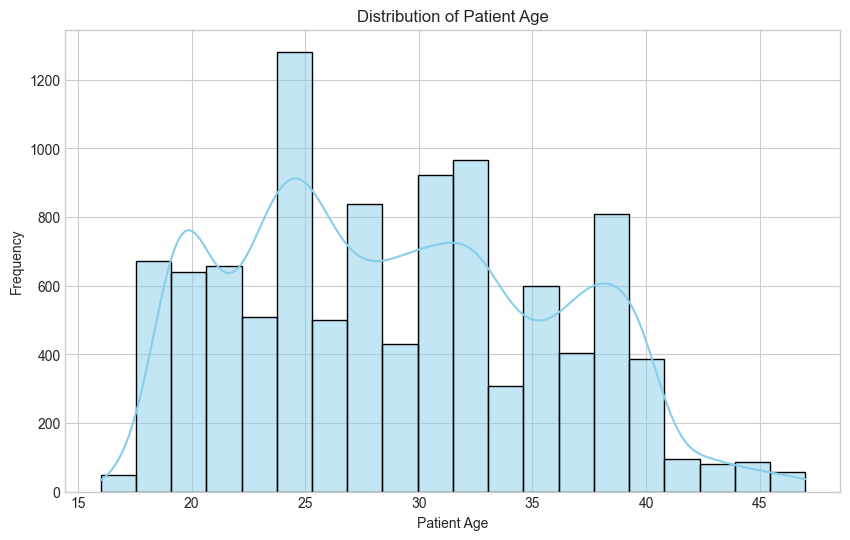

In [8]:
plt.style.use('seaborn-v0_8-whitegrid')

# Plot distribution of a numerical feature (e.g., PatientAge)
plt.figure(figsize=(10, 6))
sns.histplot(X['PatientAge'].dropna(), bins=20, kde=True, color='skyblue')
plt.title('Distribution of Patient Age')
plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.show()

C:\Users\zainm\AppData\Local\Temp\ipykernel_57524\3429264679.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=y, palette='viridis', order=y.value_counts().index)


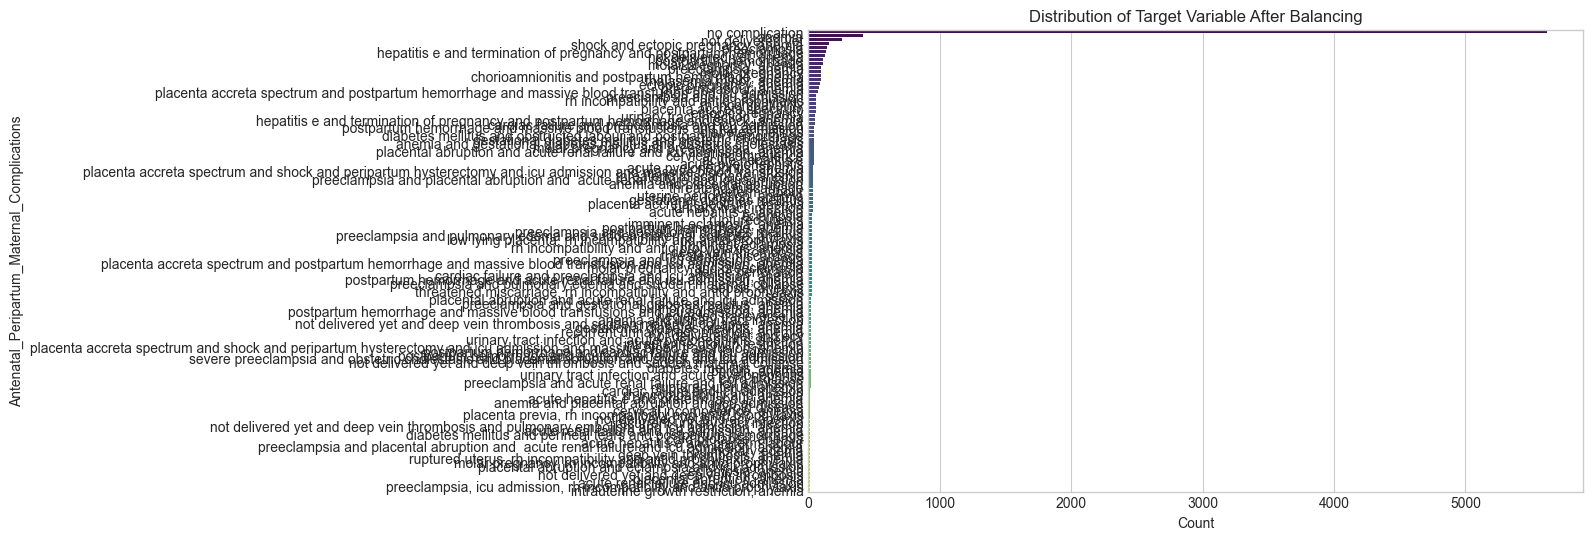

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(y=y, palette='viridis', order=y.value_counts().index)
plt.title('Distribution of Target Variable After Balancing')
plt.xlabel('Count')
plt.ylabel('Antenatal_Peripartum_Maternal_Complications')
plt.show()

In [10]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("\nData split into training (70%) and testing (30%) sets with stratification per class.")



Data split into training (70%) and testing (30%) sets with stratification per class.


In [12]:

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}



Starting model training and evaluation...

Training Logistic Regression...
Logistic Regression Accuracy: 0.7942
Classification Report for Logistic Regression:
                                                                                                                         precision    recall  f1-score   support

                                                                                                      acute hepatitis e       0.25      0.17      0.20        12
                                                                                   acute hepatitis e and preterm labour       0.80      1.00      0.89         4
                                                                           acute hepatitis e and preterm labour, anemia       0.75      0.75      0.75         4
                                                                                              acute hepatitis e, anemia       0.29      0.56      0.38         9
                                  

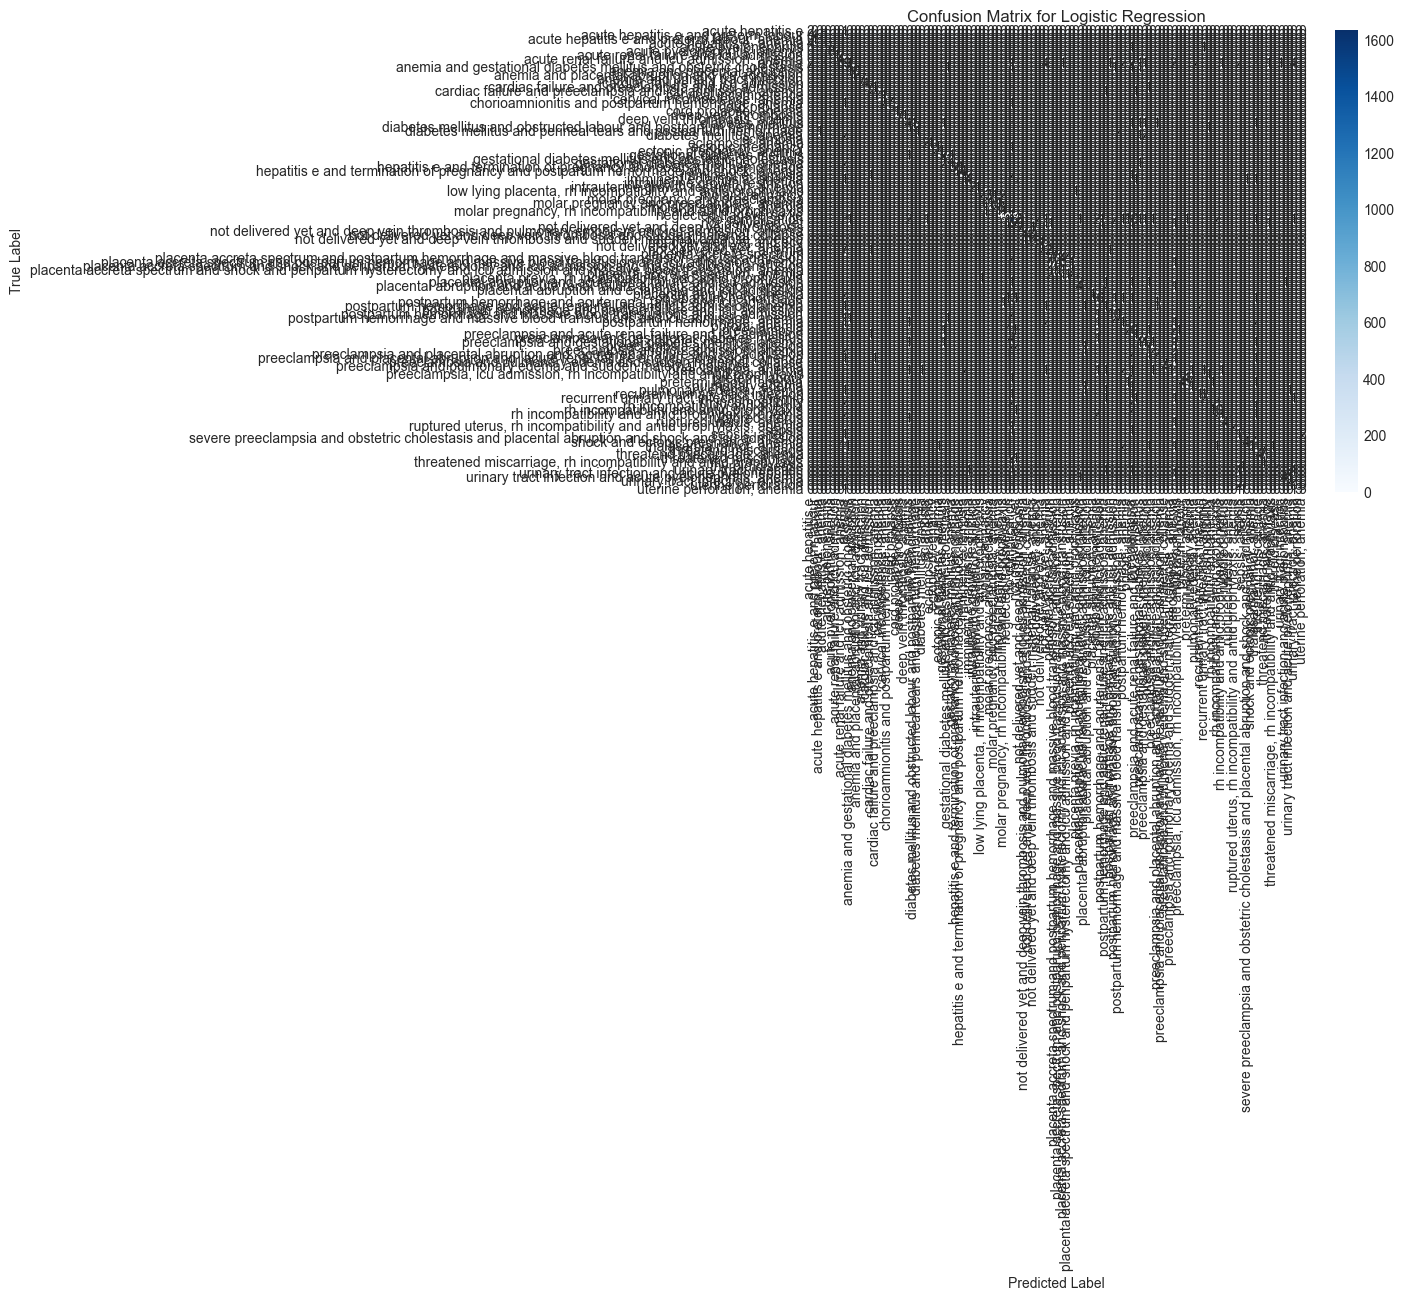


Training Random Forest...
Random Forest Accuracy: 0.8133
Classification Report for Random Forest:
                                                                                                                         precision    recall  f1-score   support

                                                                                                      acute hepatitis e       0.22      0.17      0.19        12
                                                                                   acute hepatitis e and preterm labour       1.00      1.00      1.00         4
                                                                           acute hepatitis e and preterm labour, anemia       1.00      1.00      1.00         4
                                                                                              acute hepatitis e, anemia       0.29      0.44      0.35         9
                                                                                               

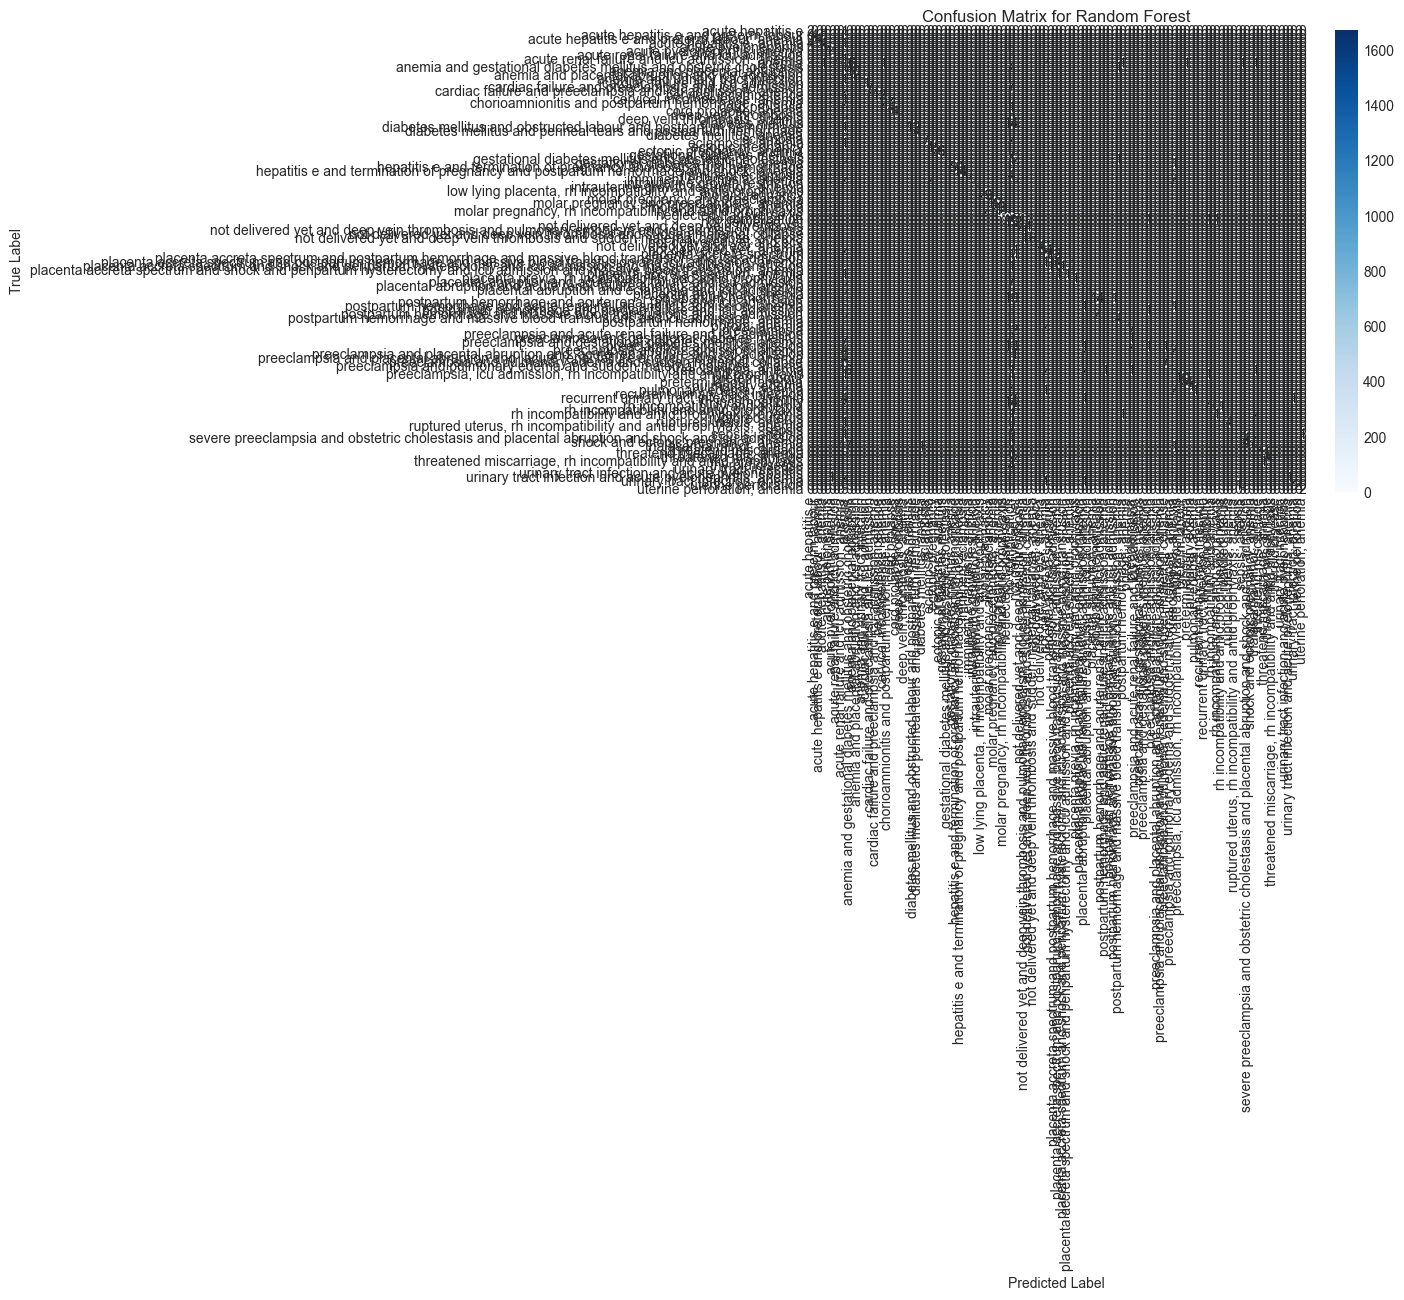


Training Gradient Boosting...


In [ ]:
results = {}
pipelines = {} # Dictionary to store trained pipelines

print("\nStarting model training and evaluation...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Create a full pipeline with the preprocessor and the model
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', model)])
    
    # Train the model
    full_pipeline.fit(X_train, y_train)
    
    # Store the trained pipeline
    pipelines[name] = full_pipeline
    
    # Make predictions
    y_pred = full_pipeline.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    
    results[name] = accuracy
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"Classification Report for {name}:\n{report}")
    
    # Optional: Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


C:\Users\zainm\AppData\Local\Temp\ipykernel_17208\3660973593.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='deep')


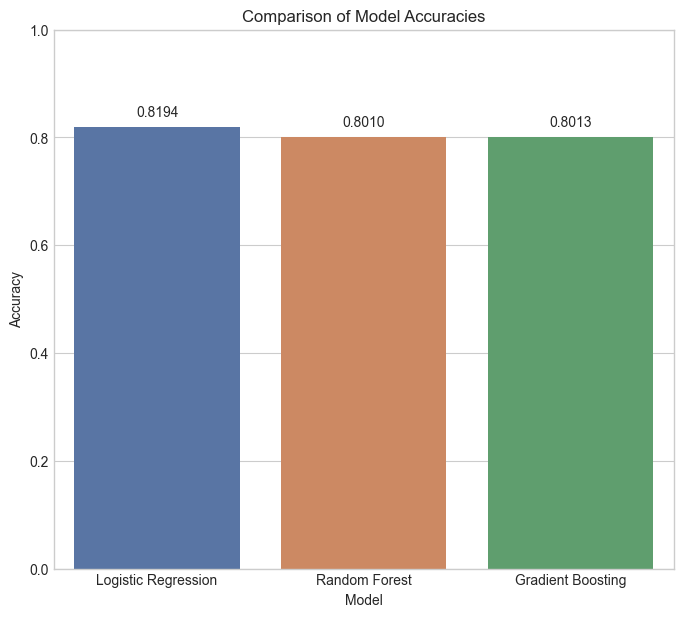

In [14]:
model_names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(8, 7))
sns.barplot(x=model_names, y=accuracies, palette='deep')
plt.title('Comparison of Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center')
plt.show()

In [15]:
best_model_name = max(results, key=results.get)
best_model_accuracy = results[best_model_name]
best_pipeline = pipelines[best_model_name]

print(f"\n--- Final Result ---")
print(f"The best performing model is: {best_model_name}")
print(f"With an accuracy of: {best_model_accuracy:.4f}")


--- Final Result ---
The best performing model is: Logistic Regression
With an accuracy of: 0.8194


In [16]:
model_filename = 'best_antenatal_complications_prediction_model.joblib'
try:
    joblib.dump(best_pipeline, model_filename)
    print(f"\nBest model saved to {model_filename}")
except Exception as e:
    print(f"\nError saving the model: {e}")


Best model saved to best_antenatal_complications_prediction_model.joblib
